In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates ## Formatear las fechas en el eje x para mostrar solo horas, minutos y segundos
import os
from datetime import datetime, timedelta, time

In [51]:
# Se crea un diccionario para almacenar los marcos de datos.
dataframes = {}

data_folder = os.path.join('..','Date') #creamos el path

#verificamos que el path sea correcto y en caso que asi sea, vemos los nombres de archivos dentro
if os.path.isdir(data_folder):
    files = os.listdir(data_folder) # guardamos la lista
    print(files)

# Se define una función para leer cada archivo y convertirlo en un dataframe
def read_file(filename):
    df = pd.read_excel(os.path.join(data_folder,filename))
    dataframes[filename] = df #Se crea un elemento del diccionario -> dataframa[CLAVE] = VALOR

#Leo todos los archivos excel
for filename in files:
    read_file(filename)

['Medicion 01-12-2023.xlsx', 'Medicion 02-03-2024.xlsx', 'Medicion 11-03-2024.xlsx', 'Medicion 15-12-2023.xlsx', 'Medicion 22-04-2024.xlsx', 'Medicion 28-12-2023.xlsx', 'Medicion 29-04-2024.xlsx', 'Medicion 30-04-2024.xlsx']


In [52]:
# Lista para almacenar los DataFrames de Temperaturas
df_list = []
# Lista para almacenar los DataFrames de DateTime
df_date_list = []

for filename in files:
    # Suponiendo que tienes un DataFrame llamado dataframes y un nombre de archivo filename
    # Primero, convierte la columna "Date" en datetime
    dataframes[filename]['Date'] = pd.to_datetime(dataframes[filename]['Date'], errors='coerce')
    # Elimino las filas con NaT en la columna "Date" como referencia.
    dataframes[filename] = dataframes[filename].dropna(subset=['Date'])
    #dataframes[filename] = dataframes[filename].dropna(subset=['T1grasa'])
    # Selecciono las columnas 3 a 11, columnas de temperaturas. Lo guardo en un nuevo datafrema df.
    df = dataframes[filename].iloc[:, 3:12]
    #Sustituyo la columna "Date"(fecha) por una columna datetime donde tengo la fecha y hora.
    dataframes[filename]["Date"]=pd.to_datetime(dataframes[filename]["Date"].dt.strftime('%Y-%m-%d') + ' ' + dataframes[filename]["Time"].astype(str))
    #Inserto la clumna Date en el dataframe df. No utiilio df["Date"]=valor porque este me inserta la columna al final
    df_date = dataframes[filename]["Date"]
     # Agregar el DataFrame a la lista de DataFrame Temperaturas
    df_list.append(df)
    # Agregar el DataFrame a la lista de DataFrame DateTimes
    df_date_list.append(df_date)




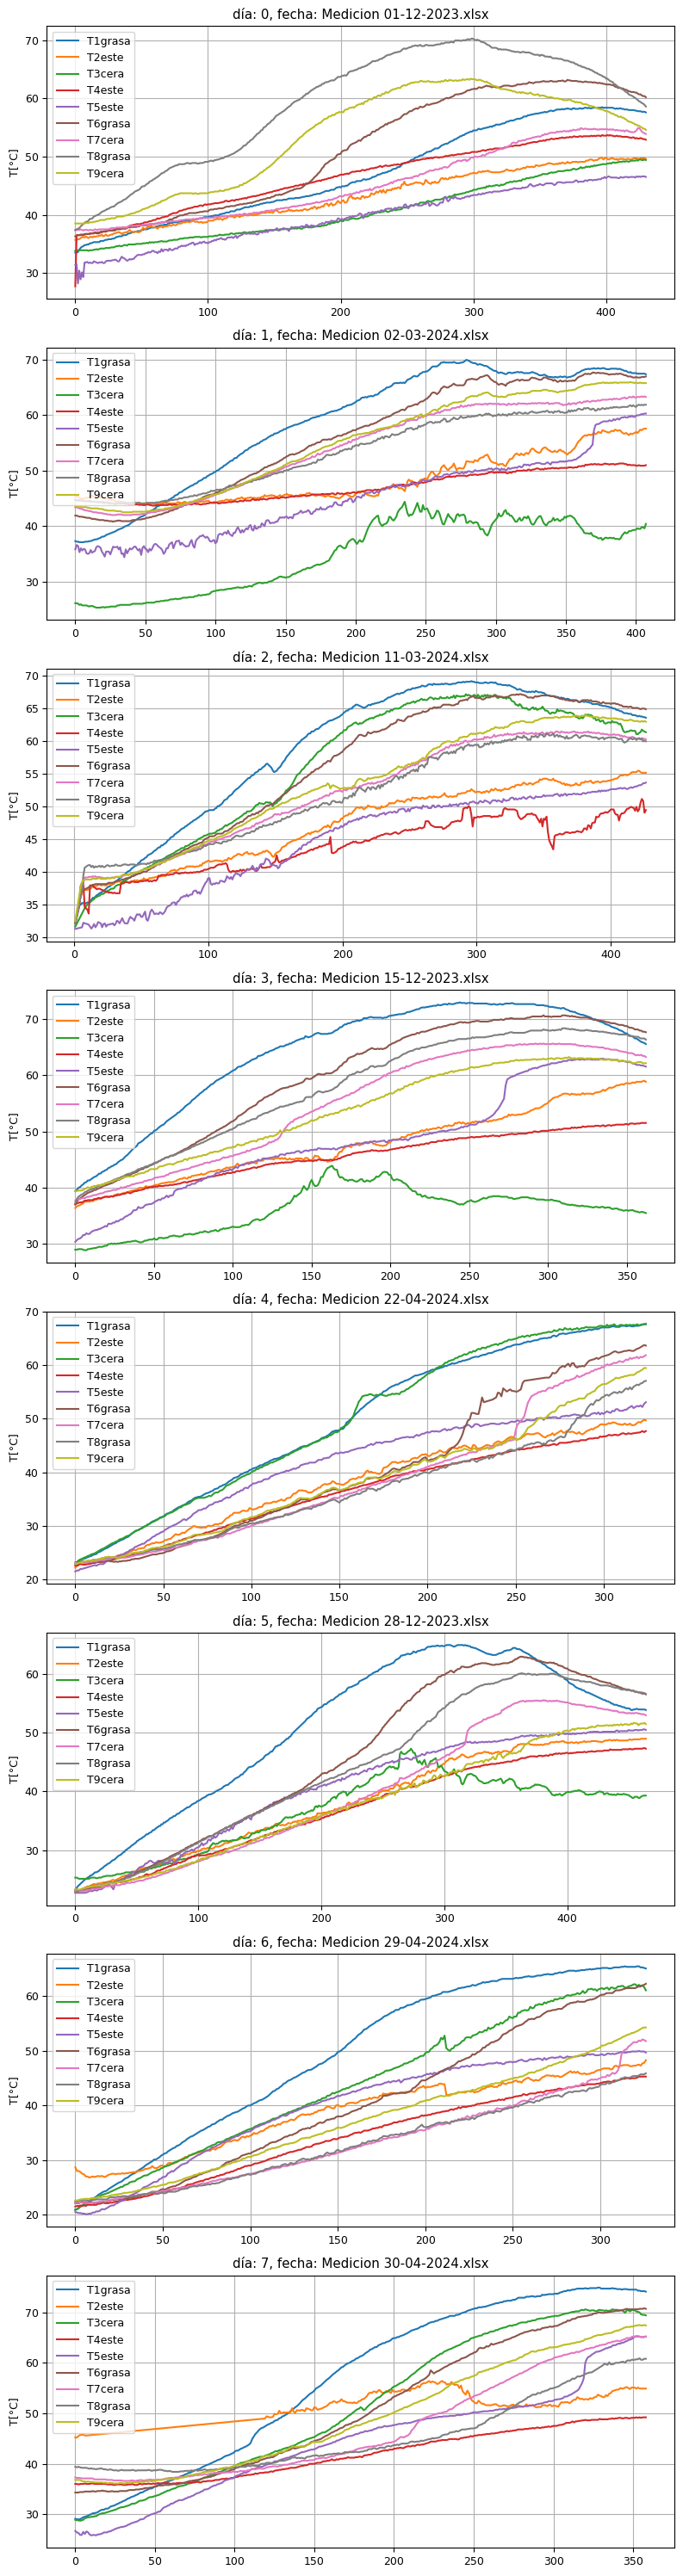

In [53]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 9}
plt.rc('font', **font)
df_columns = df_list[0].columns

fig, axs = plt.subplots(len(df_list),1, figsize=(8,30))
for i, df in enumerate(df_list):   
    for col in df_columns:
        axs[i].plot(df[col], '-', label = f"{col}")
    axs[i].set_title(f"día: {i}, fecha: {files[i]}")
    axs[i].set_ylabel("T[°C]")
    axs[i].legend(loc = 'upper left')
    axs[i].grid()
fig.tight_layout()
plt.show()

In [54]:
for i, df in enumerate(df_list):
    df_list[i] = df[:325]

,T1grasa,T2este,T3cera,T4este,T5este,T6grasa,T7cera,T8grasa,T9cera
0,39.4,36.4,29,37.1,30.4,37,37.7,37.3,39.4
1,39.6,36.7,29,37.2,30.7,37.5,37.9,38,39.4
2,40,36.8,29.1,37.3,30.9,37.9,37.9,38.4,39.5
3,40.1,36.9,29.1,37.4,31,38.1,38,38.6,39.5
4,40.4,37.1,29.1,37.4,31.2,38.3,38.1,38.8,39.5
...,...,...,...,...,...,...,...,...,...
320,70.8,56.5,36.7,50.7,62.7,70.2,65.2,67.9,63
321,70.7,56.6,36.8,50.7,62.8,70.2,65.2,67.9,63
322,70.7,56.8,36.8,50.9,62.8,70.2,65.2,67.9,63
323,70.6,56.6,36.7,50.8,62.7,70.2,65.1,67.9,62.9
